In [1]:
path = '/home/rishabh.mondal/R_P_project/Faulty_solar_panel'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [3]:
#Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
#Create the ImageFolder dataset

dataset = datasets.ImageFolder(
    root=path,
    transform=transform,
)


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split the dataset into train and pool sets
pool_set,test_set  = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset.targets)
pool_targets = [data[1] for data in pool_set]  #making a list of targets



In [6]:
len(dataset), len(pool_set), len(test_set)

(885, 708, 177)

In [7]:
print(len(pool_targets))

708


In [8]:

len(pool_set), len(test_set)

(708, 177)

In [9]:
train_set1, pool_set = train_test_split(pool_set, test_size=0.99, random_state=42, stratify=pool_targets)
len(train_set1), len(pool_set)

(7, 701)

In [10]:
# Define data loaders for train, pool, and test sets
trainloader = DataLoader(train_set1, batch_size=512, shuffle=True)
poolloader = DataLoader(pool_set, batch_size=512, shuffle=False)
testloader = DataLoader(test_set, batch_size=512, shuffle=False)


In [12]:
#ount the number of each class in the train set
class_count = {}
for _, label in train_set1:
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

{0: 2, 1: 1, 4: 1, 5: 1, 3: 1, 2: 1}


In [13]:
model=models.efficientnet_b0(pretrained=True) #finetune the model


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

In [15]:
model.classifier[1]=nn.Linear(1280,6) 
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [16]:
model = model.to(device)


In [17]:
# from torchsummary import summary
# input_shape = (3, 224, 224)
# summary(model, input_shape)

In [18]:
#zero shot learning
model.eval()
with torch.no_grad():
    corect = 0
    total = 0
    for images, labels in testloader:
        # print(images.shape)
        # print(labels.shape)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        # print(outputs)
        # print(outputs.shape)
        # print(torch.max(outputs, 1))
        _, predicted = torch.max(outputs, 1)
        # print(predicted.shape)
        # print(labels.size(0))
        total += labels.size(0)
        corect += (predicted == labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * corect / total))
    print('F1 score of the model on the test images: {}'.format(f1_score(labels.cpu(), predicted.cpu(), average='macro')))




Accuracy of the model on the test images: 13.559322033898304 %
F1 score of the model on the test images: 0.07442203186884037


In [20]:
criterion = nn.CrossEntropyLoss()
criterion??

Signature:      criterion(*args, **kwargs)
Type:           CrossEntropyLoss
String form:    CrossEntropyLoss()
File:           ~/miniconda3/envs/torch_space/lib/python3.11/site-packages/torch/nn/modules/loss.py
Source:        
class CrossEntropyLoss(_WeightedLoss):
    r"""This criterion computes the cross entropy loss between input logits
    and target.

    It is useful when training a classification problem with `C` classes.
    If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
    assigning weight to each of the classes.
    This is particularly useful when you have an unbalanced training set.

    The `input` is expected to contain the unnormalized logits for each class (which do `not` need
    to be positive or sum to 1, in general).
    `input` has to be a Tensor of size :math:`(C)` for unbatched input,
    :math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
    `K`-dimensional case. The last being useful fo

In [21]:
#train the model
losses = []
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
from tqdm.notebook import tqdm
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss/len(trainloader))
    print(f"Loss: {running_loss/len(trainloader)}")

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7248485088348389
Loss: 1.5007513761520386
Loss: 1.2860835790634155
Loss: 1.1151505708694458
Loss: 0.9356356263160706
Loss: 0.8275765180587769
Loss: 0.6639972925186157
Loss: 0.728277862071991
Loss: 0.6215664148330688
Loss: 0.5188234448432922
Loss: 0.40069082379341125
Loss: 0.3495786190032959
Loss: 0.2839629352092743
Loss: 0.2465573102235794
Loss: 0.25844377279281616
Loss: 0.2075119912624359
Loss: 0.18177291750907898
Loss: 0.1729983240365982
Loss: 0.11684275418519974
Loss: 0.1320848912000656
Loss: 0.09172777086496353
Loss: 0.14550288021564484
Loss: 0.10431452840566635
Loss: 0.08991266787052155
Loss: 0.08102992922067642
Loss: 0.07231020927429199
Loss: 0.05846713110804558
Loss: 0.05634293705224991
Loss: 0.058545179665088654
Loss: 0.050344888120889664
Loss: 0.04168414697051048
Loss: 0.04667062312364578
Loss: 0.041777580976486206
Loss: 0.051450569182634354
Loss: 0.033824365586042404
Loss: 0.02795194275677204
Loss: 0.06049387529492378
Loss: 0.027675287798047066
Loss: 0.027968298643827

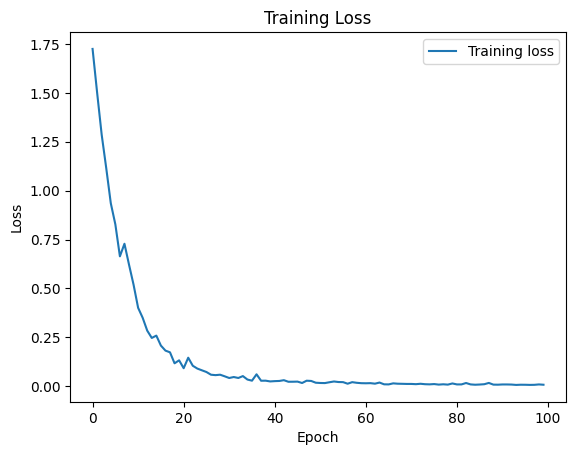

In [22]:
#plot the loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(["Training loss"]);

In [23]:
model.eval()
with torch.no_grad():
    corect = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        corect += (predicted == labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * corect / total))
    print('F1 score of the model on the test images: {}'.format(f1_score(labels.cpu(), predicted.cpu(), average='macro')))

Accuracy of the model on the test images: 26.55367231638418 %
F1 score of the model on the test images: 0.22260064660780687


In [24]:
model.eval()
with torch.no_grad():
    corect = 0
    total = 0
    for images, labels in poolloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        corect += (predicted == labels).sum().item()
    print('Accuracy of the model on the pool images: {} %'.format(100 * corect / total))
    print('F1 score of the model on the pool images: {}'.format(f1_score(labels.cpu(), predicted.cpu(), average='macro')))

Accuracy of the model on the pool images: 32.52496433666191 %
F1 score of the model on the pool images: 0.2700959871469206


In [102]:
import torch
from sklearn.metrics import f1_score
import numpy as np
# Set the model to evaluation mode
model.eval()

# Initialize lists to store entropy values and predictions
entropy_list = []
predictions_list = []

# Iterate through the pool set
with torch.no_grad():
    for images, labels in poolloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate probabilities and entropy
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        print(probabilities.shape)
        entropy = -torch.sum(probabilities * torch.log(probabilities), dim=1)
        
        # Append entropy values and predictions to lists
        entropy_list.extend(entropy.cpu().numpy())
        predictions_list.extend(predicted.cpu().numpy())

# Find the index of the data point with the highest entropy (most uncertain)
uncertain_index = np.argmax(entropy_list)
uncertain_point = pool_set[uncertain_index]  # Assuming poolset is your dataset
print(uncertain_index)
#visualize the uncertain point


# # Get the label of the uncertain point
uncertain_label = predictions_list[uncertain_index]

# # Print the uncertain point and its label
# print('Uncertain Point:', uncertain_point)
print('Label of Uncertain Point:', uncertain_label)

# # Calculate accuracy and F1 score of the model on the pool images
# accuracy = 100 * corect / total
# f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')

# print('Accuracy of the model on the pool images: {} %'.format(accuracy))
# print('F1 score of the model on the pool images: {}'.format(f1))


torch.Size([512, 6])
torch.Size([189, 6])
72
Label of Uncertain Point: 0


In [118]:
print(entropy_list)
#find the max value of entropy
max_entropy = max(entropy_list)
print(max_entropy)
#find the min value of entropy
min_entropy = min(entropy_list)
print(min_entropy)
#find the index of the max value of entropy
index_max_entropy = entropy_list.index(max_entropy)
print(index_max_entropy)
#find the index of the min value of entropy
index_min_entropy = entropy_list.index(min_entropy)
print(index_min_entropy)


[1.7795115, 1.7706895, 1.7709221, 1.7802843, 1.7065516, 1.778682, 1.7143517, 1.769363, 1.774797, 1.7402493, 1.684726, 1.7631555, 1.7603192, 1.7312734, 1.7747705, 1.7726331, 1.7809411, 1.773049, 1.7334365, 1.7638484, 1.7479203, 1.6881224, 1.7611067, 1.7516699, 1.6994271, 1.7842575, 1.7873781, 1.6531461, 1.7349849, 1.7721288, 1.7726331, 1.7640588, 1.6711389, 1.7641978, 1.7611306, 1.7712421, 1.7494142, 1.7451364, 1.7703996, 1.7865034, 1.7626104, 1.765486, 1.7858061, 1.7820028, 1.7599653, 1.7792163, 1.7760701, 1.7604642, 1.7484617, 1.7846708, 1.7653222, 1.7460607, 1.6581311, 1.6942114, 1.7525795, 1.7904387, 1.765574, 1.7572733, 1.7711332, 1.7651488, 1.703764, 1.785679, 1.7840347, 1.7488935, 1.7646339, 1.7593834, 1.7358806, 1.7346408, 1.7816103, 1.769552, 1.7311051, 1.7834713, nan, 0.53363883, 1.7716082, 1.7817925, 1.7524614, 1.7773111, 1.7561367, 1.7606314, 0.028518755, 1.7706496, nan, 1.7893014, 1.6611245, 1.7598124, 1.7367768, 1.7724906, 1.7766671, 1.7606196, 1.6814662, 1.7709324, 1.7436

In [103]:
#print the most uncertain point entropy
print('Entropy of the most uncertain point:', entropy_list[uncertain_index])


Entropy of the most uncertain point: nan


In [94]:
entropy_list
# print(entropy_list[uncertain_index])

[1.7795115,
 1.7706895,
 1.7709221,
 1.7802843,
 1.7065516,
 1.778682,
 1.7143517,
 1.769363,
 1.774797,
 1.7402493,
 1.684726,
 1.7631555,
 1.7603192,
 1.7312734,
 1.7747705,
 1.7726331,
 1.7809411,
 1.773049,
 1.7334365,
 1.7638484,
 1.7479203,
 1.6881224,
 1.7611067,
 1.7516699,
 1.6994271,
 1.7842575,
 1.7873781,
 1.6531461,
 1.7349849,
 1.7721288,
 1.7726331,
 1.7640588,
 1.6711389,
 1.7641978,
 1.7611306,
 1.7712421,
 1.7494142,
 1.7451364,
 1.7703996,
 1.7865034,
 1.7626104,
 1.765486,
 1.7858061,
 1.7820028,
 1.7599653,
 1.7792163,
 1.7760701,
 1.7604642,
 1.7484617,
 1.7846708,
 1.7653222,
 1.7460607,
 1.6581311,
 1.6942114,
 1.7525795,
 1.7904387,
 1.765574,
 1.7572733,
 1.7711332,
 1.7651488,
 1.703764,
 1.785679,
 1.7840347,
 1.7488935,
 1.7646339,
 1.7593834,
 1.7358806,
 1.7346408,
 1.7816103,
 1.769552,
 1.7311051,
 1.7834713,
 nan,
 0.53363883,
 1.7716082,
 1.7817925,
 1.7524614,
 1.7773111,
 1.7561367,
 1.7606314,
 0.028518755,
 1.7706496,
 nan,
 1.7893014,
 1.6611245,

In [100]:
print(entropy_list[uncertain_index])

nan


In [62]:
print(uncertain_index)
print(uncertain_label)

72
0


In [130]:
probabilities[188]

tensor([0.2691, 0.1373, 0.1542, 0.1143, 0.1665, 0.1587], device='cuda:0')

In [127]:
# Get the predicted probability for the most uncertain point

# predicted_probability = probabilities[uncertain_index, uncertain_label]
predicted_probability = probabilities[72]


# Print the predicted probability
print('Predicted Probability for the Most Uncertain Point:', predicted_probability.item())


RuntimeError: a Tensor with 6 elements cannot be converted to Scalar

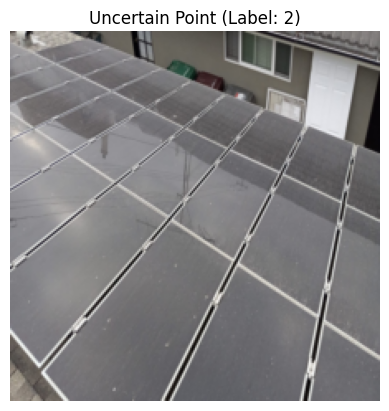

In [121]:
import matplotlib.pyplot as plt

# Get the image corresponding to the uncertain point
uncertain_image, uncertain_label = pool_set[188]

# Convert the image tensor to numpy array and transpose it to the correct shape
uncertain_image = uncertain_image.permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(uncertain_image)
plt.title(f'Uncertain Point (Label: {uncertain_label})')
plt.axis('off')
plt.show()


In [50]:
import numpy as np
a=torch.rand(6,4)   
entropy_list = []
predictions_list = []
probabilities=torch.nn.functional.softmax(a, dim=1)
entropy = -torch.sum(probabilities * torch.log(probabilities), dim=1)
entropy_list.append(entropy)
print(entropy_list)
uncertain_index = np.argmax(entropy_list)
uncertain_point = pool_set[uncertain_index]
print(uncertain_index)

# print(soft)
# print(soft.shape)
# soft=soft.reshape(-1)
# print(soft.shape)
# print(soft) 
# the uncertainty is calculated by the entropy of the softmax
# torch.distributions.Categorical(probs=soft)
# uncertainty=torch.distributions.Categorical(probs=probabilities).entropy()
# print(uncertainty)

[tensor([1.3839, 1.3689, 1.3762, 1.3297, 1.3536, 1.3792])]
0


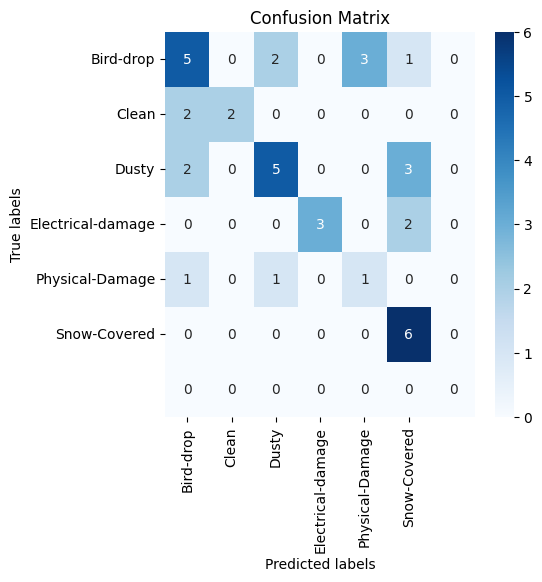

In [124]:
#plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Find the uncertain samples from pool set using entropy, margin sampling ,least confidence sampling, random sampling

